In [1]:
import os
os.chdir("../../test_data/system_tests/Spectronaut_LargeFC/")

In [2]:
import os

INPUT_FILE = "20210210_154121_S209-S-1-240min_Reportv2.tsv"
SAMPLEMAP_FILE = "samples.map.tsv"
RESULTS_DIR = "results"
PROTEIN_SUBSET_FOR_NORMALIZATION="housekeeping_proteins.tsv" #"housekeeping_genes.tsv"
SPECTRONAUT_FILE = "MP-LFC-OT.xlsx"
CONDPAIR = ("S1", "S2")
SHARED_PEPTIDES_BETWEEN_SPECIES_FILE = "../databases/intersecting_peptides_human_yeast_cael_ecoli.tsv"

using input type spectronaut_fragion_isotopes_protein
removed pre existing /Users/constantin/workspace/alphaquant/test_data/system_tests/Spectronaut_LargeFC/20210210_154121_S209-S-1-240min_Reportv2.tsv.ml_info_table.tsv
start processeing condpair ('S1', 'S2')
normalized within conditions
without missingvals (if applicable)
complete dataset
shift comparison by -0.13408215835584514
normalized between conditions
t_ion2nonan_sw 2.9102959632873535
t_intensity_selection 28.110579013824463
t_ion2nonan_sw 3.1200897693634033
t_intensity_selection 28.783915042877197
checked 0 of 1138682 ions
checked 2000 of 1138682 ions
checked 4000 of 1138682 ions
checked 6000 of 1138682 ions
checked 8000 of 1138682 ions
checked 10000 of 1138682 ions
checked 12000 of 1138682 ions
checked 14000 of 1138682 ions
checked 16000 of 1138682 ions
checked 18000 of 1138682 ions
checked 20000 of 1138682 ions
checked 22000 of 1138682 ions
checked 24000 of 1138682 ions
checked 26000 of 1138682 ions
checked 28000 of 1138682 

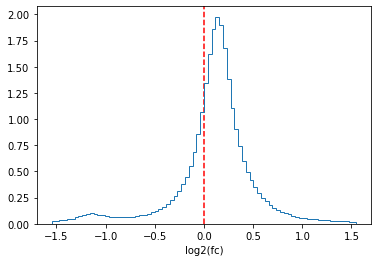

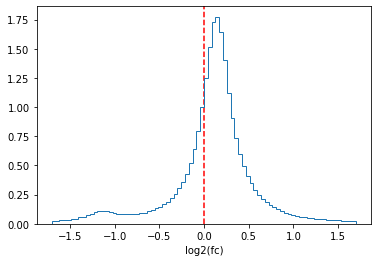

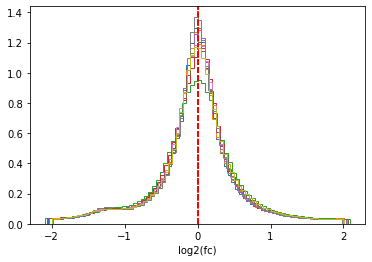

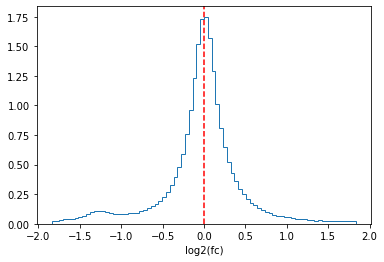

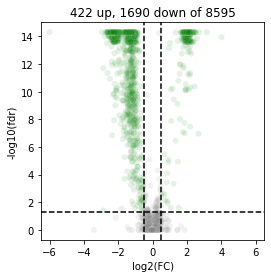

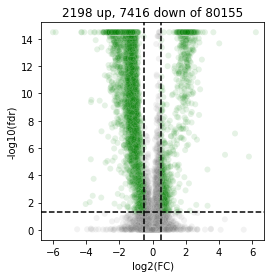

In [3]:
import alphaquant.run_pipeline as run_pipeline

run_pipeline.run_pipeline(input_file=INPUT_FILE, samplemap_file=SAMPLEMAP_FILE, results_dir=RESULTS_DIR, runtime_plots=True, protein_subset_for_normalization_file=PROTEIN_SUBSET_FOR_NORMALIZATION, 
                        annotation_columns=["PG.Organisms"], condpairs_list=[CONDPAIR], peptides_to_exclude_file=SHARED_PEPTIDES_BETWEEN_SPECIES_FILE, input_type_to_use="spectronaut_fragion_isotopes_protein")

In [4]:
import pandas as pd

alphaquant_file = f"{RESULTS_DIR}/{CONDPAIR[0]}_VS_{CONDPAIR[1]}.results.tsv"
df_alphaquant = pd.read_csv(alphaquant_file, sep='\t')[["protein", "log2fc", "fdr", "quality_score", "PG.Organisms", "total_intensity"]]
df_alphaquant = df_alphaquant.rename(columns={"PG.Organisms": "organism", "total_intensity" : "intensity_alphaquant", "fdr" : "fdr_alphaquant", "log2fc" : "log2fc_alphaquant"})
df_alphaquant = df_alphaquant.dropna(subset=["organism"])
df_alphaquant = df_alphaquant[[";" not in x for x in df_alphaquant["organism"]]]

df_spectronaut = pd.read_excel(SPECTRONAUT_FILE, sheet_name=2)
display(df_spectronaut)
display(df_alphaquant)

,Unnamed: 0,Protein,Compare,log2FC,pvalue,adjusted.pvalue,Method,Dataset,Label,Tlog2FC
0,1,A0A061ACL3;O76618;Q965I6,S209-S-1-240min-S209-S-2-240min,-1.543028,0.000784,0.004198,protein.linear.MS1.MS2,MP_LFC,1,-1.0
1,2,A0A061ACR1;F5GUA3;Q22498;Q2XN02,S209-S-1-240min-S209-S-2-240min,-0.969898,0.019239,0.075389,protein.linear.MS1.MS2,MP_LFC,1,-1.0
2,3,A0A061AD21;A0A061AJI9;C1P640;C1P641;G5EEV6;Q21313,S209-S-1-240min-S209-S-2-240min,-1.487534,0.000239,0.001515,protein.linear.MS1.MS2,MP_LFC,1,-1.0
3,4,A0A078BTL9;Q9NA34,S209-S-1-240min-S209-S-2-240min,0.152486,0.104453,0.230693,protein.linear.MS1.MS2,MP_LFC,1,-1.0
4,5,A0A0K3AUC2,S209-S-1-240min-S209-S-2-240min,-1.212320,0.000003,0.000093,protein.linear.MS1.MS2,MP_LFC,1,-1.0
...,...,...,...,...,...,...,...,...,...,...
8032,8033,Q9Y6X5,S209-S-1-240min-S209-S-2-240min,0.344851,0.049231,0.151656,protein.linear.MS1.MS2,MP_LFC,0,0.0
8033,8034,Q9Y6X9;Q9Y6X9-2,S209-S-1-240min-S209-S-2-240min,0.017987,0.557449,0.657020,protein.linear.MS1.MS2,MP_LFC,0,0.0
8034,8035,Q9Y6Y0,S209-S-1-240min-S209-S-2-240min,0.117552,0.250315,0.381341,protein.linear.MS1.MS2,MP_LFC,0,0.0
8035,8036,Q9Y6Y8,S209-S-1-240min-S209-S-2-240min,0.122045,0.092544,0.216111,protein.linear.MS1.MS2,MP_LFC,0,0.0


,protein,log2fc_alphaquant,fdr_alphaquant,quality_score,organism,intensity_alphaquant
0,Q8TB37,0.367905,7.183346e-02,0.009956,Homo sapiens,3.449743e+06
1,O95352,0.054460,9.999597e-01,0.027107,Homo sapiens,1.288712e+07
2,Q9UNP9,0.063618,5.125557e-01,0.030288,Homo sapiens,2.513439e+07
3,P09972,0.022986,9.999597e-01,0.075812,Homo sapiens,1.757378e+08
4,Q8N4T8,-0.100384,9.999597e-01,0.007514,Homo sapiens,5.056769e+06
...,...,...,...,...,...,...
8590,P0A9R7,-1.677418,1.330375e-10,0.000448,Escherichia coli (strain K12),3.275688e+05
8591,Q9Y4K1,-0.089364,9.999597e-01,0.001304,Homo sapiens,1.023545e+05
8592,Q22968,-1.530390,6.607113e-13,0.000693,Caenorhabditis elegans,5.326121e+04
8593,Q9BUP3-3,-0.085128,9.999597e-01,0.001011,Homo sapiens,1.820193e+05


,organism,hits_alphaquant,max_hits_alphaquant,allowed_decoy_hits_alphaquant
0,Caenorhabditis elegans,1222,1327,NaN
1,Escherichia coli (strain K12),452,492,NaN
2,Homo sapiens,56,0,113.0
3,Saccharomyces cerevisiae (strain ATCC 204508 /...,429,483,NaN


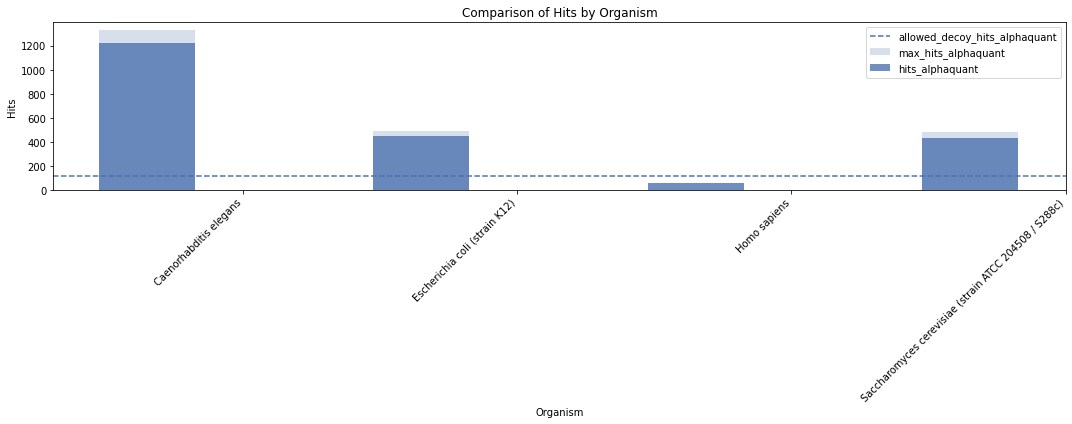

In [5]:
import alphaquant.benchm.sensitivity as aq_benchm_sensititivy
classification_benchmark = aq_benchm_sensititivy.RatioClassificationTableGenerator(df_alphaquant, method_suffixes=["_alphaquant"] ,decoy_organism="Homo sapiens")
classification_df = classification_benchmark.per_species_results_df
display(classification_df)
ax = aq_benchm_sensititivy.plot_sighits_barplot(classification_benchmark.per_species_results_df, ['_alphaquant'], 'Homo sapiens')



In [6]:
def assert_fdr_is_not_violated(classification_df, suffix = "_alphaquant",  decoy_organism="Homo sapiens"):
    idx_of_decoy_organism = classification_df[classification_df["organism"] == decoy_organism].index
    num_allowed_hits = classification_df.loc[idx_of_decoy_organism, f"allowed_decoy_hits{suffix}"].values[0]
    num_allowed_hits_w_tolerance = int(1.1*num_allowed_hits)
    num_actual_hits =  classification_df.loc[idx_of_decoy_organism,f"hits{suffix}"].values[0]

    assert num_actual_hits < num_allowed_hits_w_tolerance , "more false postives than expected"



def assert_sensitivity_is_as_expected(classification_df, suffix="_alphaquant"):
    organism2numsig = dict(zip(classification_df["organism"],classification_df[f"hits{suffix}"]))
    assert organism2numsig["Saccharomyces cerevisiae (strain ATCC 204508 / S288c)"] > 370, "sensitivity of Saccharomyces cerevisiae (strain ATCC 204508 / S288c) lower than expected"
    assert organism2numsig["Escherichia coli (strain K12)"] > 445, "sensitivity of Escherichia coli lower than expected"
    assert organism2numsig["Caenorhabditis elegans"] > 1100, "sensitivity of Caenorhabditis elegans lower than expected"

assert_fdr_is_not_violated(classification_df)
assert_sensitivity_is_as_expected(classification_df)

In [7]:
%reload_ext autoreload
%autoreload 2

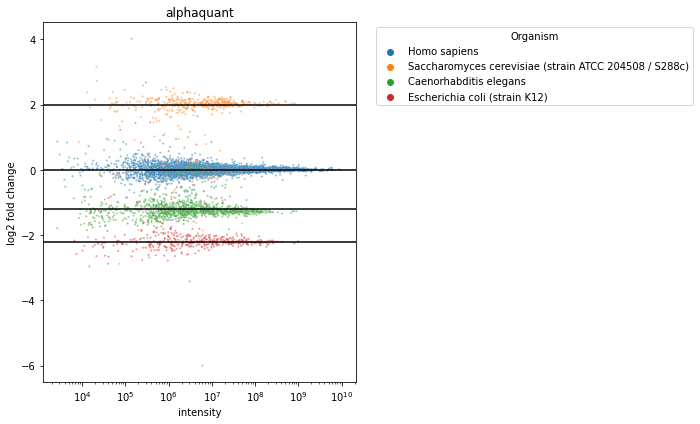

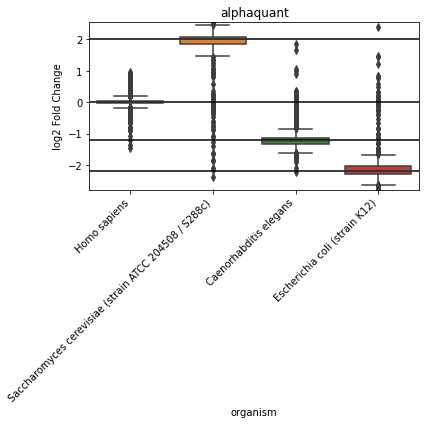

In [8]:
import alphaquant.benchm.ratios as aq_benchm_ratios
df_alphaquant_onlyyeast = df_alphaquant[df_alphaquant["organism"].str.contains("Saccharomyces cerevisiae")]
scatter_plotter = aq_benchm_ratios.MixedSpeciesScatterPlotter(df_combined=df_alphaquant, method_suffixes=["_alphaquant"], expected_log2fcs=[-2.2, -1.2,0,  2], figure_size=[10, 6])
aq_benchm_ratios.MixedSpeciesBoxPlotter(df_combined=df_alphaquant, method_suffixes=["_alphaquant"], expected_log2fcs=[-2.2, -1.2,0,  2], figure_size=[6, 6])


